In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
import pandas as pd

In [2]:
df = pd.read_csv('Assets/Earthquake database 01011677 to 11042025.csv', index_col='DATE', parse_dates=True)

### Major earthquakes in history

According to an article in *Annals of the Academy of Romanian Scientists Series on Physics and Chemistry Sciences, Volume 8, Number 1/2023* "we notice a grouping tendency of the strongest earthquakes" in Romania, so by using the data extracted from the INFP site, managed to reproduce the plot presented in the above mentioned article.<br> (for the complete article, see *Assets folder*)

In [4]:
big_mask = df['Mw'] > 7
medium_mask = df['Mw'].between(6.5, 7)
low_mask = df['Mw'].between(6, 6.49)

big_ones = df[big_mask].reset_index()
medium = df[medium_mask].reset_index()
low = df[low_mask].reset_index()

In [5]:
# Computes the differences in years between earthquakes above 7 Mw.
def compute_diffs(dataframe):
    dataframe = dataframe.copy()
    dataframe['Y_DIFF'] = (dataframe.index.diff() / pd.Timedelta(days=365)).fillna(0).astype('int16')
    return dataframe

computed_diff_df = compute_diffs(df[big_mask])

# Identifies the years when the first eq over 7 Mw happened, but only if there is a gap of 30 years between eqs
gap_mask = computed_diff_df['Y_DIFF'] > 30
gap = computed_diff_df[gap_mask]['Y_DIFF']

# Calculates the place where a vertical line can be placed on the figure so that a period of eq activity is identified
# Puts the v-line 5 years before the earthquake year, to avoid overlapping with the eq itself
def compute_activity_start(gap):
    activity_start = []
    for item in gap.index:
        activity_start.append(item - pd.Timedelta(365 * 5, unit='D'))
    activity_start.pop()  # Eliminating last element of the list due to data inaccuracy
    return activity_start

# Calculates the end of the previous activity period based on the start of the activity.
def compute_activity_end(gap):
    activity_end = []
    for item in gap.index:
        activity_end.append(item - pd.Timedelta((gap.loc[item] - 5) * 365, unit='D'))
    activity_end.pop()
    return activity_end

activity_start = compute_activity_start(gap)
activity_end = compute_activity_end(gap)

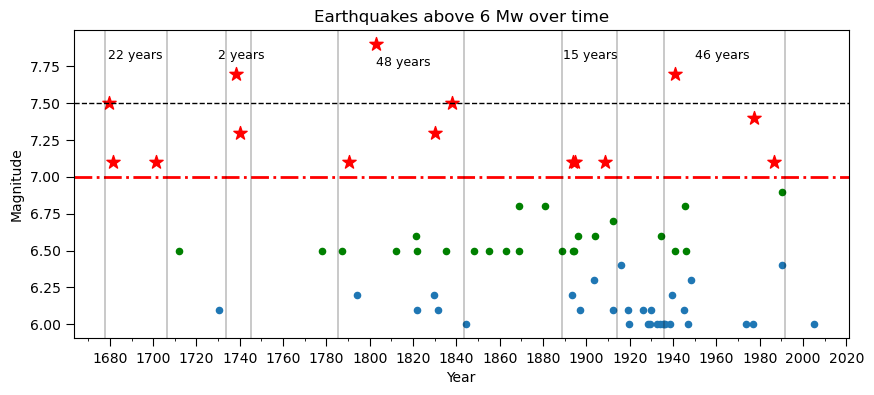

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

big_ones.plot(kind='scatter', y='Mw', x='DATE',
              marker='*', s=100, c='r',
              ax=ax
             )
medium.plot(kind='scatter', y='Mw', x='DATE',
            c='g',
            ax=ax
           )
low.plot(kind='scatter', y='Mw', x='DATE',
         ax=ax
        )

ax.set(title='Earthquakes above 6 Mw over time', xlabel='Year', ylabel='Magnitude')
ax.axhline(y=7, color='r', linestyle='dashdot', linewidth=2)
ax.axhline(y=7.5, color='k', linestyle='--', linewidth=1)

ax.xaxis.set_major_locator(YearLocator(base=20))
ax.xaxis.set_minor_locator(YearLocator(base=10))
ax.tick_params(which='major', length=6)


# Placing vertical lines according to calulcations in previous cell
line_params = {'linewidth': 0.3, 'color': 'k'}
def plot_vlines(dates, ax, params):
    for date in dates:
        ax.axvline(x=date, **params)

plot_vlines(activity_start, ax, line_params)
plot_vlines(activity_end, ax, line_params)

# Placing the line for the first and last occurence of the eq above 7.
first_line = big_ones['DATE'].iloc[0] - pd.Timedelta(680, unit='D') # 680 days, because otherwise error due to pandas datetime limit
last_line = big_ones['DATE'].iloc[-1] + pd.Timedelta(365*5, unit='D')

ax.axvline(x=first_line, **line_params)
ax.axvline(x=last_line, **line_params)


# Hard coding the coordinates, because this information does not need automation. The data will stay the same,
# even if new earthquakes will be added later.
x_dates = ['1679-01-01', '1730-01-01', '1803-01-01', '1889-01-01', '1950-01-01']
y_magnitude = [7.8, 7.8, 7.75, 7.8, 7.8]
s_text = ['22 years', '2 years', '48 years', '15 years', '46 years']

for xi, yi, st in zip(x_dates, y_magnitude, s_text):
    ax.text(x=pd.to_datetime(xi), y=yi, s=st, size=9)


plt.show()

#### **As compared to the plot from the article mentioned above:**

<img src='Assets/Fig5_article.png' width='850' height='400'>